# Teaching task: Descriptive analyses
Natalia Vélez, October 2021

In [1]:
%matplotlib inline

import os, json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
from matplotlib.patches import Rectangle
from matplotlib import colors
import seaborn as sns

sns.set_context('talk')
sns.set_style('white')

# Make directory to store plots in 
os.makedirs('plots/examples_agg', exist_ok=True) # avg heatmaps
os.makedirs('plots/examples_ind', exist_ok=True) # ind subjects

Load behavioral data:

In [44]:
excluded_subs = [3, 17] # TODO: Do this reproducibly

teaching_df = pd.read_csv('outputs/teaching_behavior.csv')
teaching_df = teaching_df[~teaching_df.subject.isin(excluded_subs)]
teaching_df['problem_idx'] = teaching_df['problem_idx'].astype(np.int)
teaching_df['ex_idx'] = teaching_df['ex_idx'].astype(np.int)
teaching_df['problem'] = teaching_df['problem'].astype(np.int)

print(teaching_df.shape)
teaching_df.tail()

(3360, 9)


,subject,run,problem_idx,ex_idx,onset,problem,order,example,rating
3583,30,30,2,1,194.60,28,"['D', 'A', 'C', 'B']","[3, 2]",2.0
3584,30,30,2,2,209.35,28,"['D', 'A', 'C', 'B']","[1, 3]",4.0
3585,30,30,3,0,254.95,13,"['D', 'B', 'A', 'C']","[2, 2]",0.0
3586,30,30,3,1,268.95,13,"['D', 'B', 'A', 'C']","[3, 2]",2.0
3587,30,30,3,2,283.85,13,"['D', 'B', 'A', 'C']","[3, 3]",3.0


Load problems:

In [3]:
with open('inputs/problems.json', 'r') as f:
    problems = json.load(f)

## Individual responses

In [38]:
def plot_subject_examples(sub, prob_idx):
    # Load data for selected problem
    block = teaching_df[(teaching_df['subject'] == sub) & (teaching_df['problem'] == prob_idx)]
    prob = problems[prob_idx]

    # Find order in which alternatives were presented
    order = block.iloc[0]['order']
    order = re.findall('[A-Z]', order)
    true_h = prob['A']

    # Split up figure layout
    fig=plt.figure(constrained_layout=True, figsize=(8,7.25))
    grid = plt.GridSpec(3,4, figure=fig)
    prob_axes = [plt.subplot(grid[:1,c]) for c in range(4)]
    ex_ax = plt.subplot(grid[1:,:2])
    rating_ax = plt.subplot(grid[1:,2:])

    fig.suptitle('sub-%02d: Problem #%i' % (sub, prob_idx))

    ## TEACHING PROBLEM
    labels = ['A', 'B', 'C', 'D']
    pad = 0.2

    # Plot each hypothesis
    for idx, opt in enumerate(order):
        sns.heatmap(prob[opt], ax=prob_axes[idx], square=True, cbar=False, xticklabels=False, yticklabels = [' ', ' ', ' ', ' ', ' '], cmap='Greys', linecolor='#aaa', linewidths=1)

        if opt == 'A':
            prob_axes[idx].set(title = '*%s*' % labels[idx])
        else:
            prob_axes[idx].set(title = labels[idx])


    ## EXAMPLES SELECTED
    true_cm = colors.LinearSegmentedColormap.from_list('true_extent', ['#fff', '#ccc'])
    ex_cm = ['#11286B', '#2E6A88', '#4BACA4']

    sns.heatmap(true_h, square=True, cbar=False, xticklabels=False, yticklabels=False, cmap=true_cm, linecolor='#aaa', linewidths=1, ax=ex_ax)

    for _, row in block.iterrows():
        ex = re.findall('[0-9]', row['example'])
        ex = [int(coord) for coord in ex]

        ex_rect = Rectangle(ex, 1, 1, facecolor=ex_cm[row['ex_idx']], edgecolor='#aaa', linewidth=1)
        ex_ax.add_patch(ex_rect)

        text = ex_ax.text(ex[0]+.5, ex[1]+.5, row['ex_idx']+1, ha='center', va='center', color='w', fontweight='bold')
    ex_ax.set(title='Examples')

    ## RATINGS
    rating_ax.plot(block.ex_idx+1, block.rating, marker='o')
    rating_ax.set(xlabel='Example', ylabel = None, xlim=(0.5,3.5), ylim=(0.5,5.5), 
                  xticks = np.arange(1,4), yticks = np.arange(1,6),
                  aspect=.5, title='Ratings')

    return fig

TypeError: expected string or bytes-like object

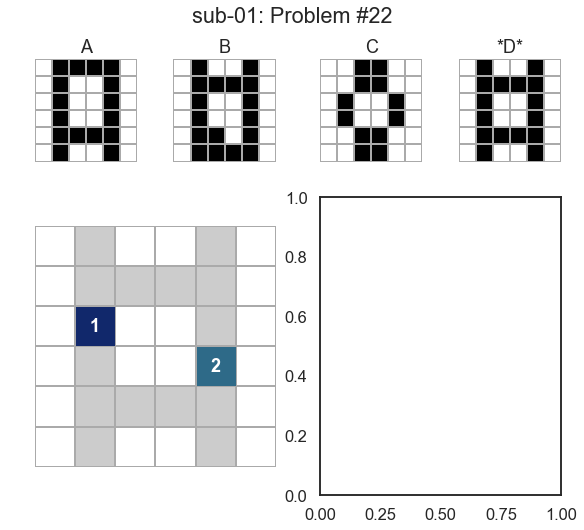

In [43]:
for name, group in teaching_df.groupby()

        fig = plot_subject_examples(sub, prob)
        plt.savefig('plots/examples_ind/sub-%02d_problem-%02d.png' % (sub, prob))
        fig.close()

## Aggregate plots

Helper function: Count how often each pixel is selected as an example

In [6]:
def example_frequencies(prob_idx):
    # Find true hypothesis
    prob = problems[prob_idx]

    # Tally number of examples
    examples = teaching_df[teaching_df['problem'] == prob_idx].copy()
    examples = examples[examples['example'].notna()]
    example_count = np.zeros((6,6))

    for _, row in examples.iterrows():
        ex = re.findall('[0-9]', row['example'])
        ex = [int(coord) for coord in ex]

        example_count[ex[0], ex[1]] += 1

    # Convert counts -> frequencies
    example_freq = example_count/np.sum(example_count) 
    return example_freq


array([[0.        , 0.        , 0.24050633, 0.11392405, 0.        ,
        0.        ],
       [0.        , 0.07594937, 0.        , 0.        , 0.05063291,
        0.        ],
       [0.12658228, 0.        , 0.        , 0.        , 0.        ,
        0.10126582],
       [0.11392405, 0.        , 0.        , 0.        , 0.        ,
        0.02531646],
       [0.        , 0.        , 0.        , 0.        , 0.01265823,
        0.        ],
       [0.        , 0.        , 0.06329114, 0.07594937, 0.        ,
        0.        ]])

Helper function: Plot examples and trial-by-trial ratings for a given teaching problem

In [31]:
def plot_problem(prob_idx):
    # Load examples
    prob = problems[prob_idx]
    true_h = np.array(prob['A'])
    freqs = example_frequencies(prob_idx) # examples

    # Split up figure layout
    fig=plt.figure(constrained_layout=True, figsize=(8,7.25))
    grid = plt.GridSpec(3,4, figure=fig)
    prob_axes = [plt.subplot(grid[:1,c]) for c in range(4)]
    ex_ax = plt.subplot(grid[1:,:2])
    rating_ax = plt.subplot(grid[1:,2:])

    fig.suptitle('Problem %i' % prob_idx)

    ## TEACHING PROBLEM
    labels = ['A', 'B', 'C', 'D']
    pad = 0.2

    # Plot each hypothesis
    for idx, opt in enumerate(labels):
        sns.heatmap(prob[opt], ax=prob_axes[idx], square=True, cbar=False, xticklabels=False, yticklabels = [' ', ' ', ' ', ' ', ' '], cmap='Greys', linecolor='#aaa', linewidths=1)

        if opt == 'A':
            prob_axes[idx].set(title = '*%s*' % labels[idx])
        else:
            prob_axes[idx].set(title = labels[idx])

    # Plot examples
    sns.heatmap(freqs, ax=ex_ax, cbar=False, square=True, cmap='viridis', mask=true_h==0, linewidth=1)
    ex_ax.set(title='Examples', xticklabels=[], yticklabels=[])

    # Plot ratings
    ratings = teaching_df[teaching_df['problem'] == prob_idx].copy() # ratings
    sns.pointplot(data=ratings, x='ex_idx', y='rating', ax=rating_ax)
    rating_ax.set(title='Ratings', xlabel='Trial', ylabel='', xlim=(-0.5, 2.5), ylim=(0.5,4.5),
                 yticks=(1,2,3,4))
    
    return fig

/Users/nvelez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/Users/nvelez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/Users/nvelez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control th

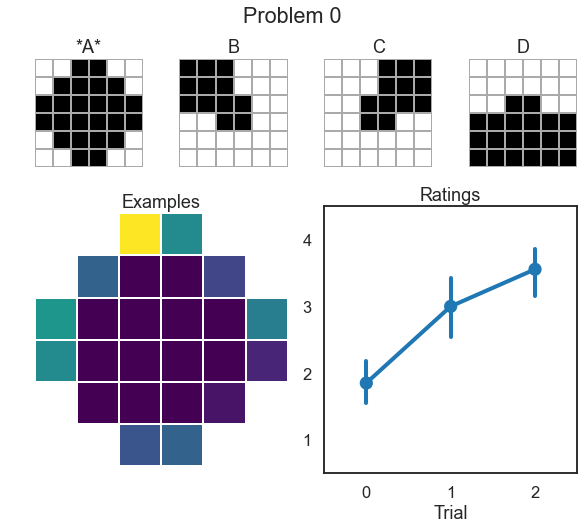

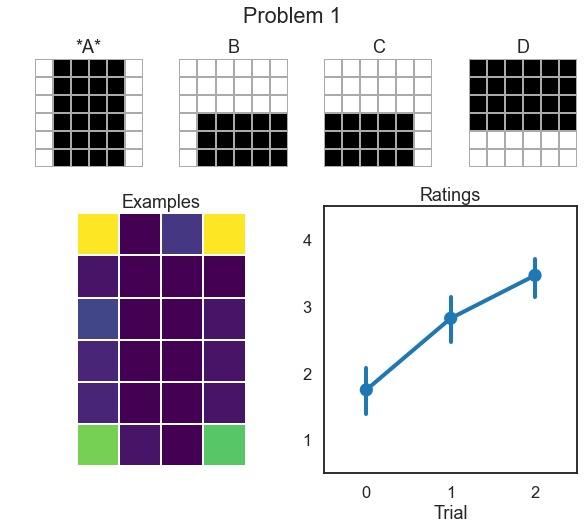

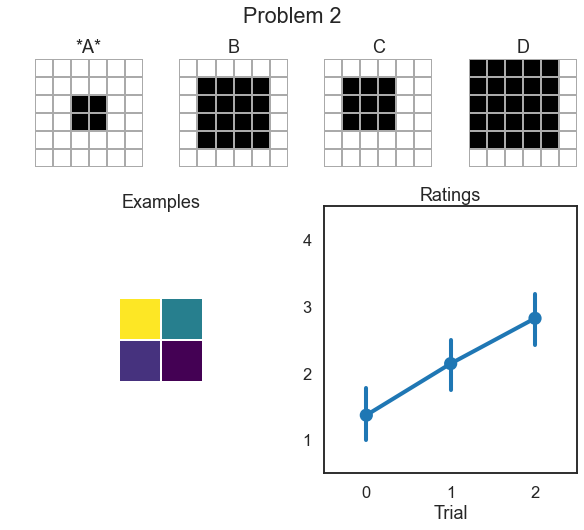

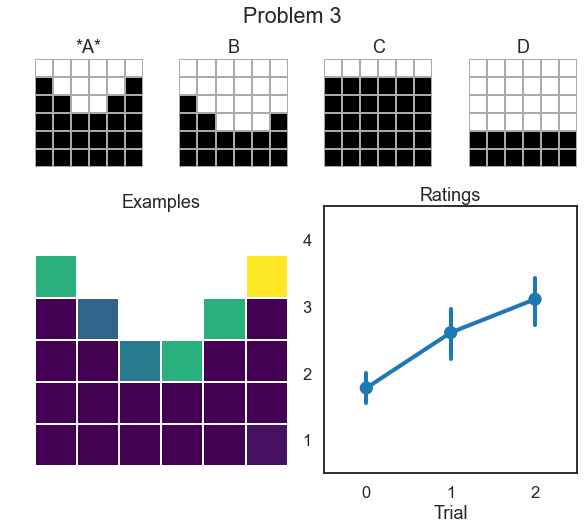

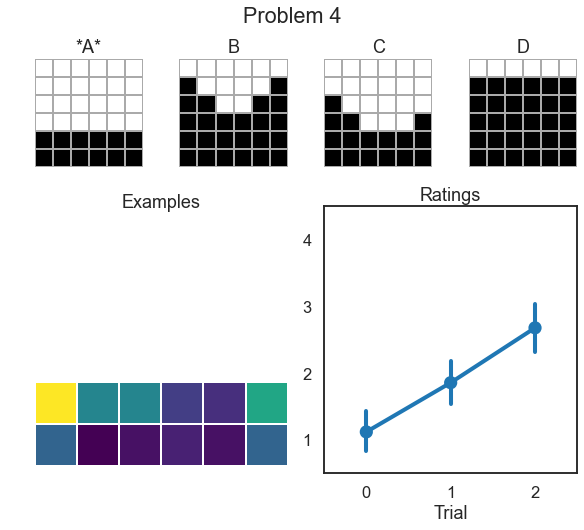

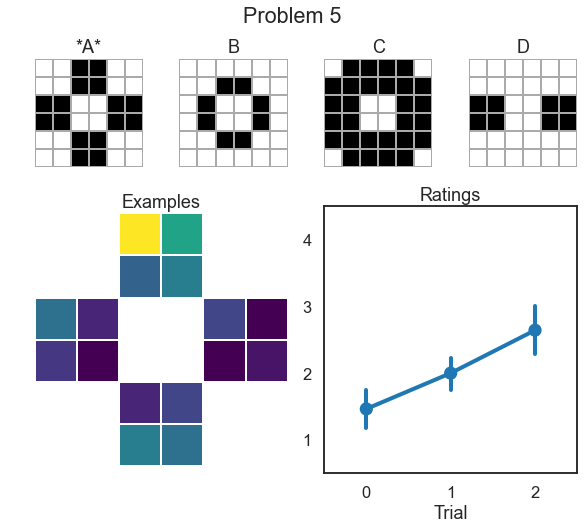

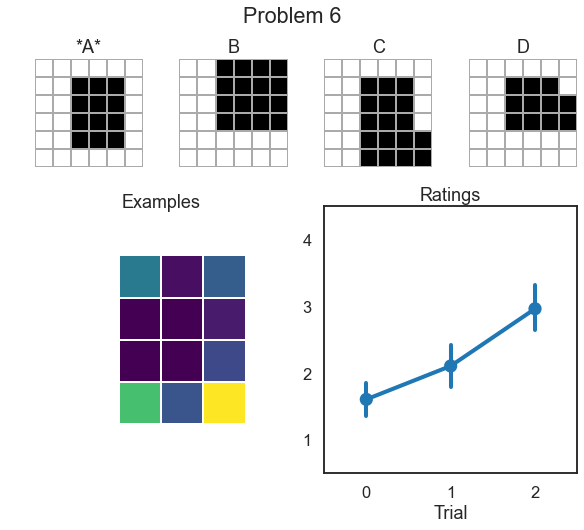

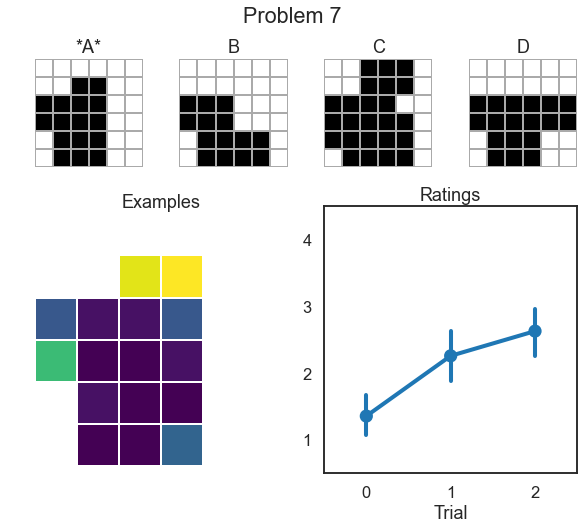

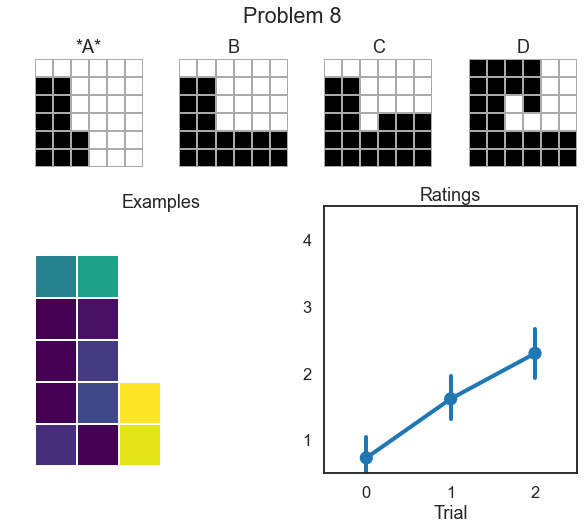

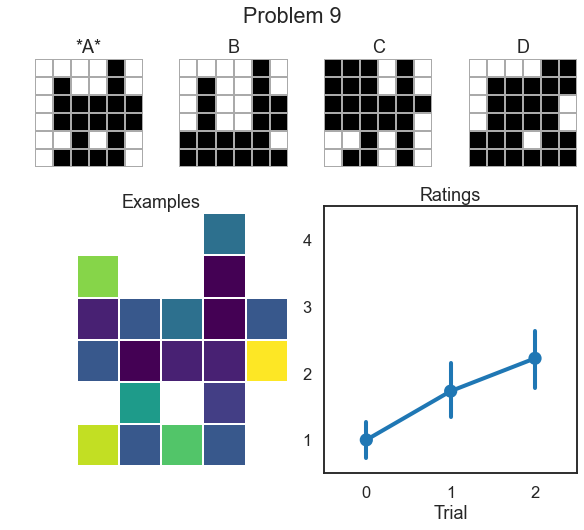

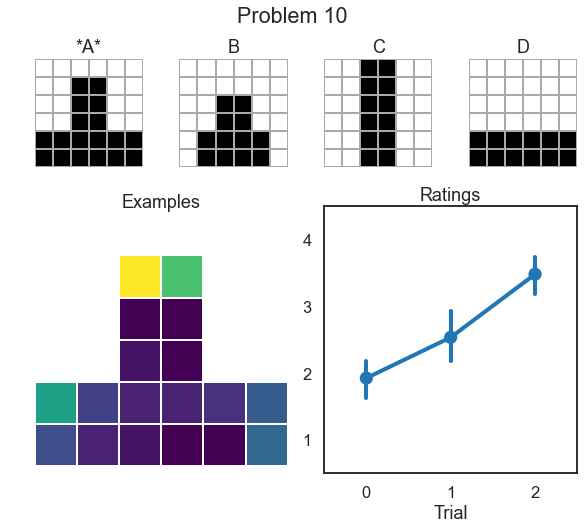

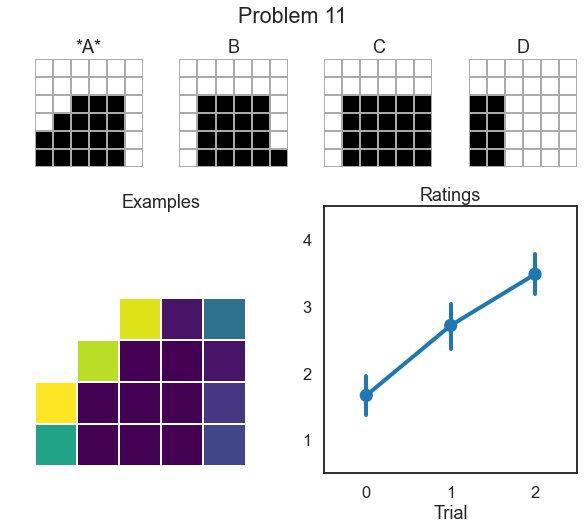

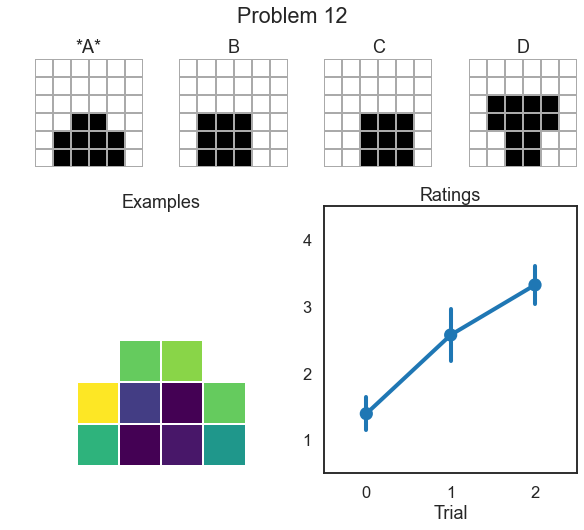

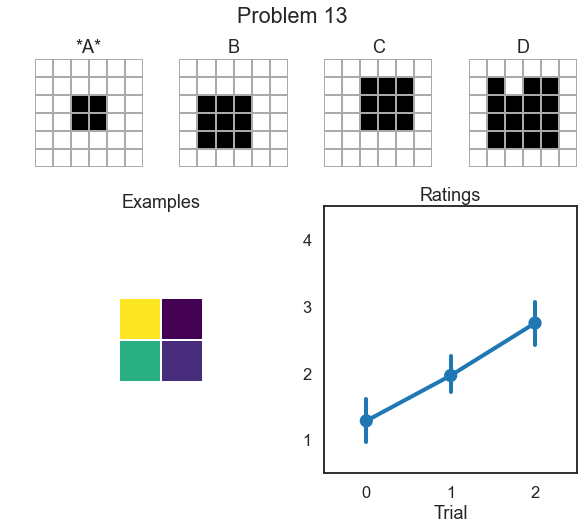

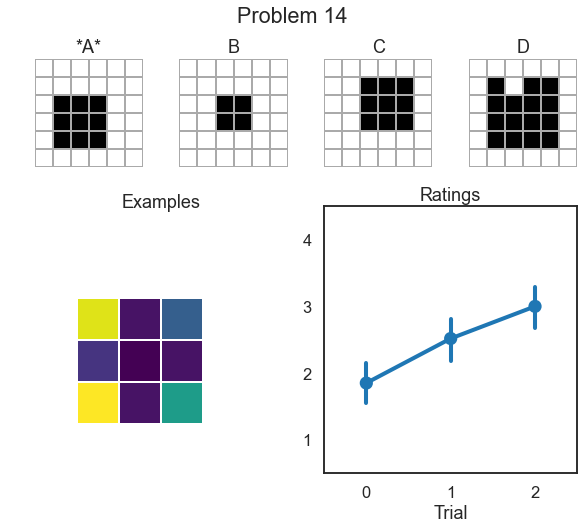

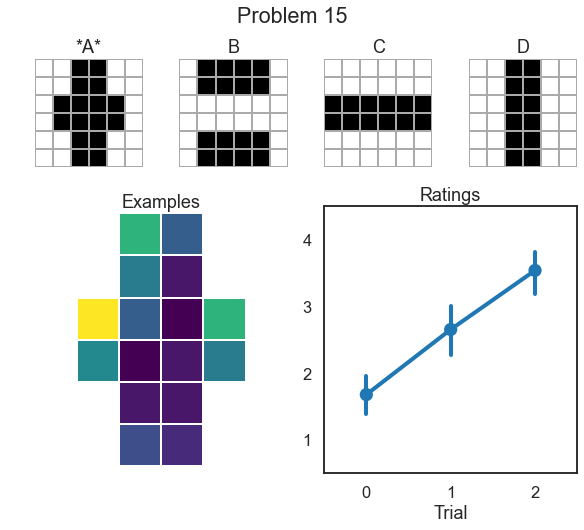

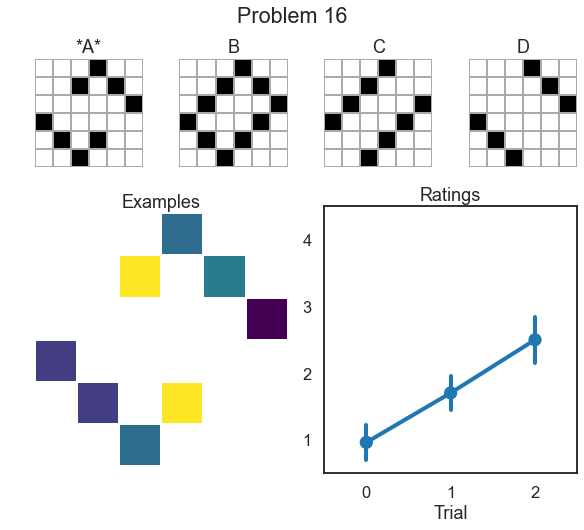

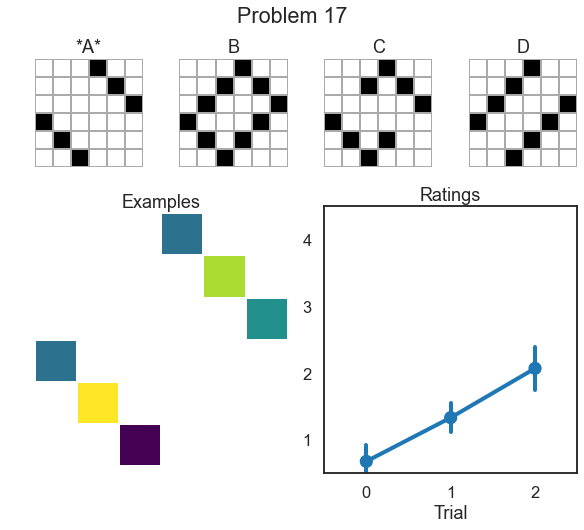

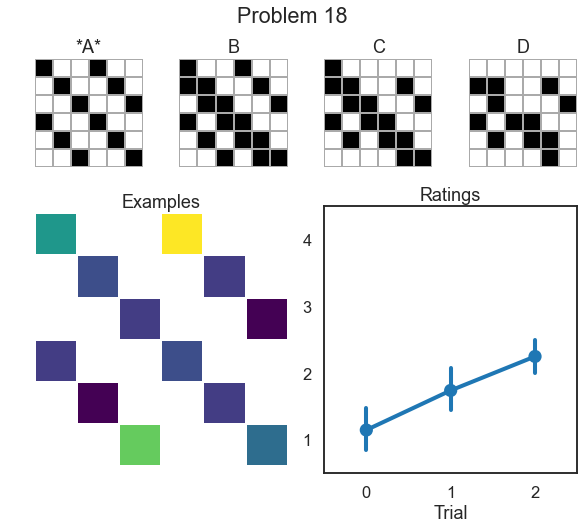

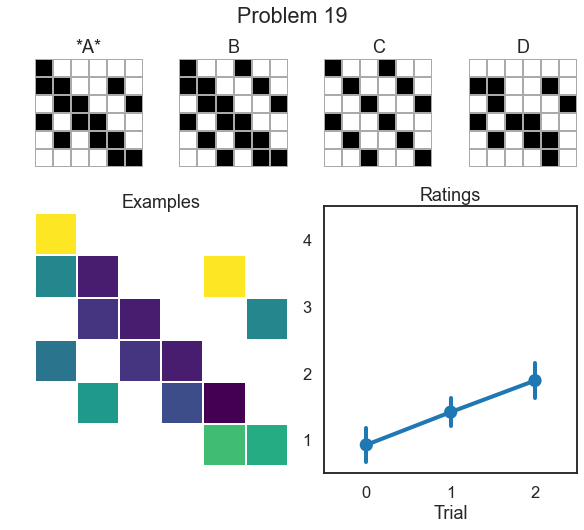

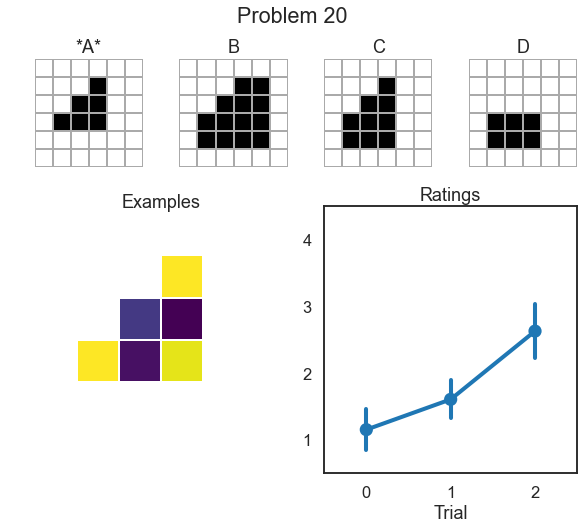

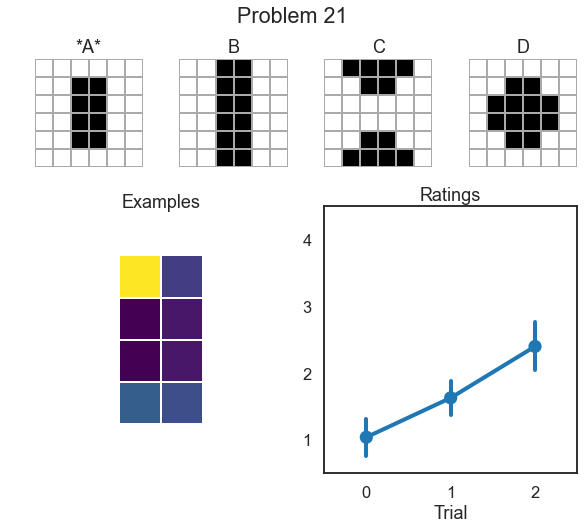

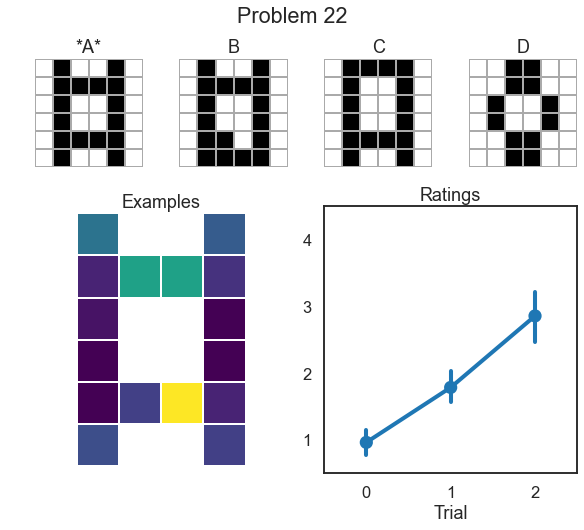

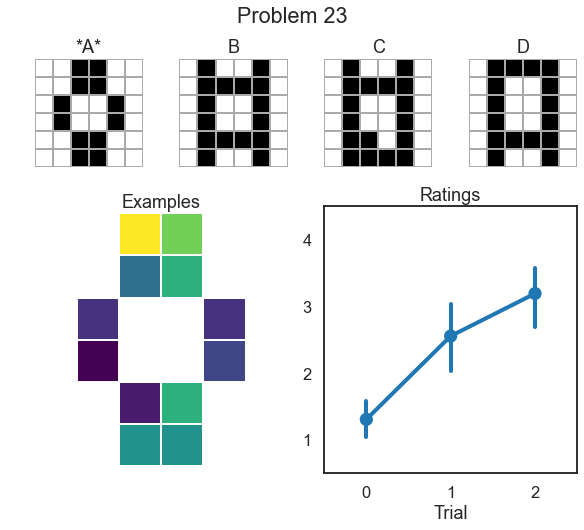

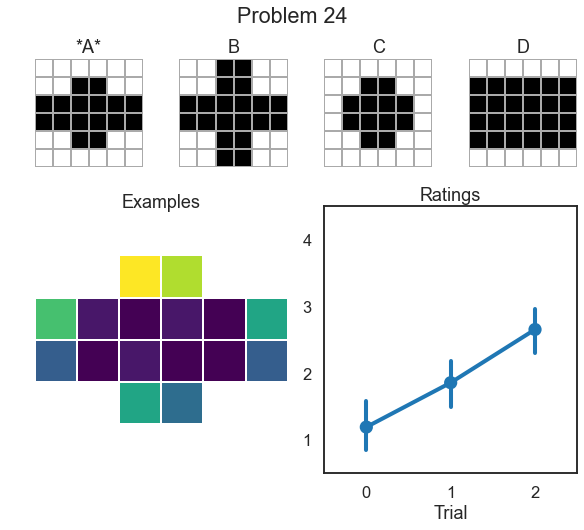

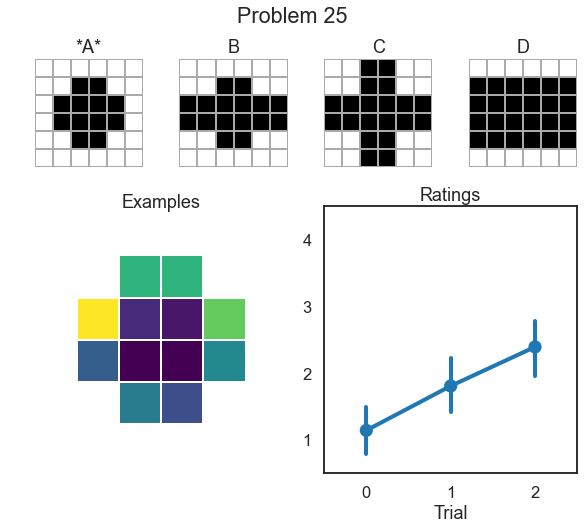

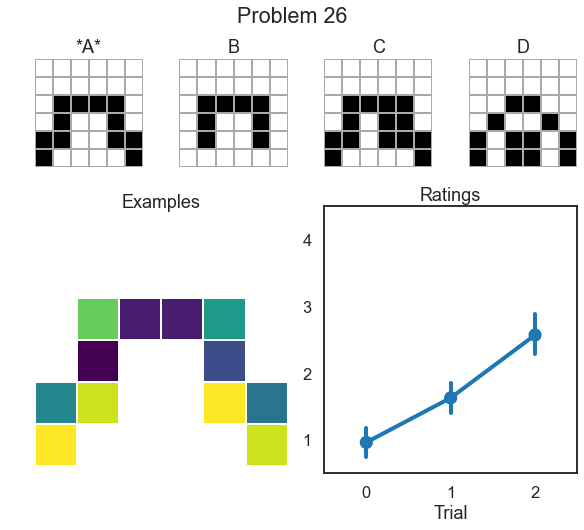

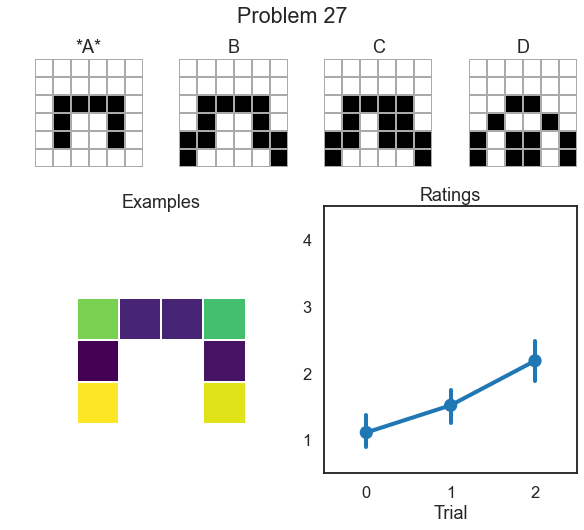

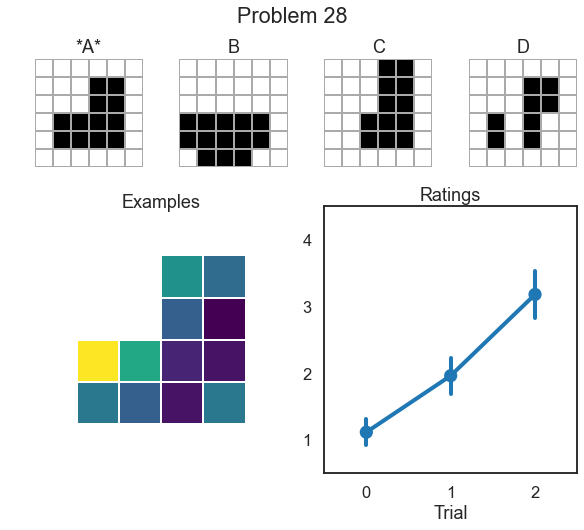

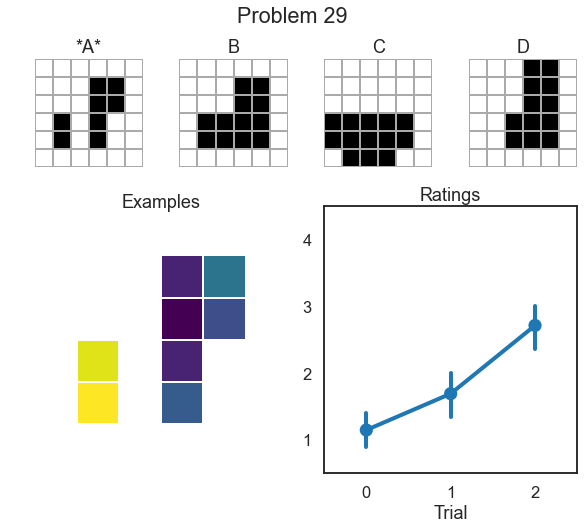

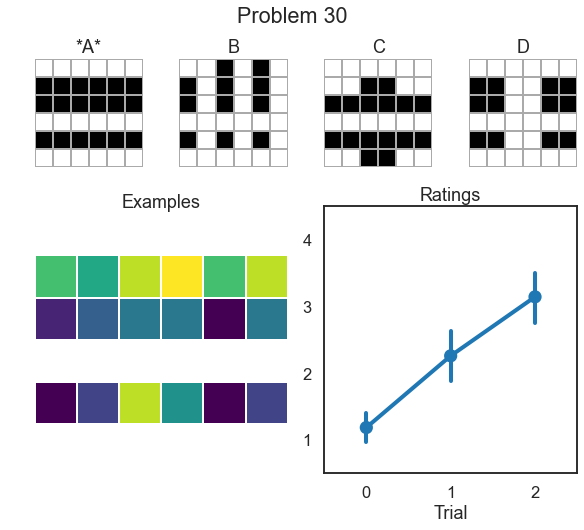

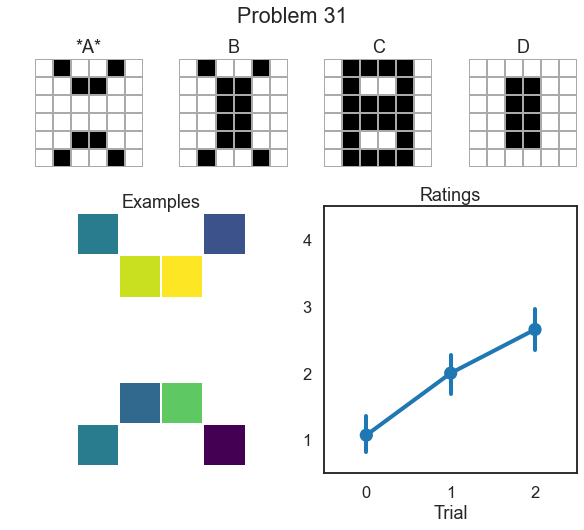

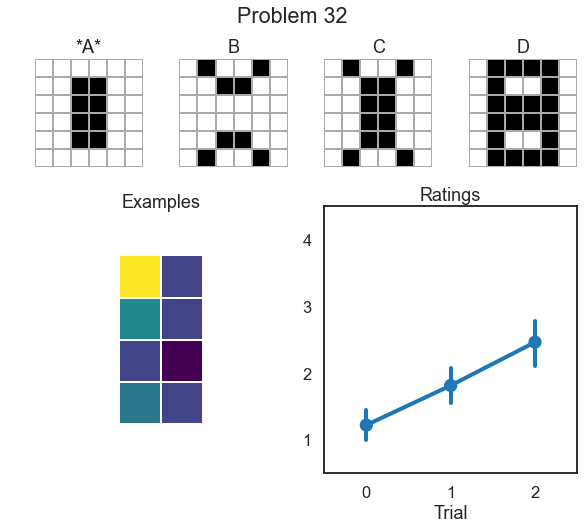

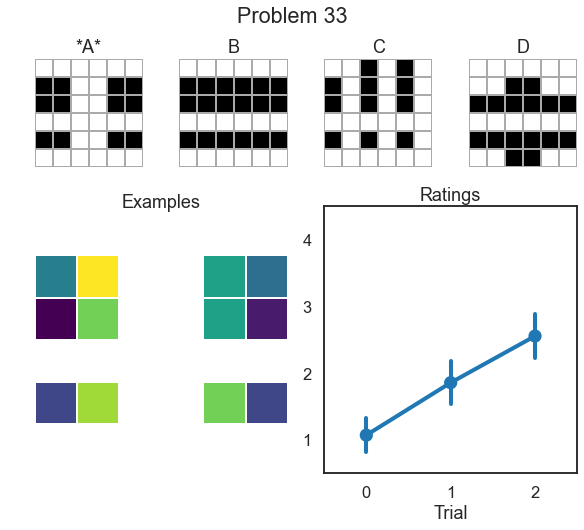

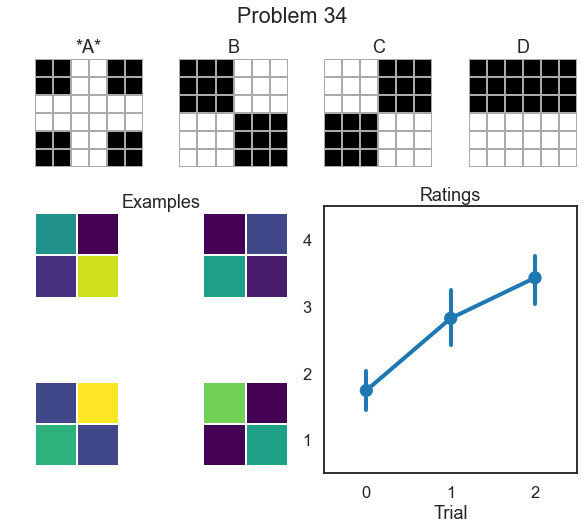

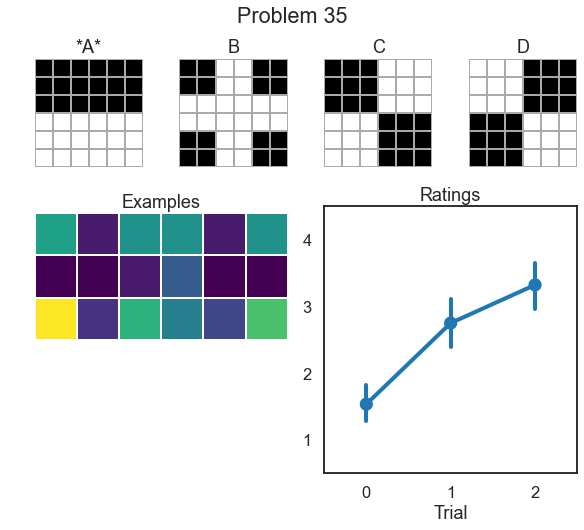

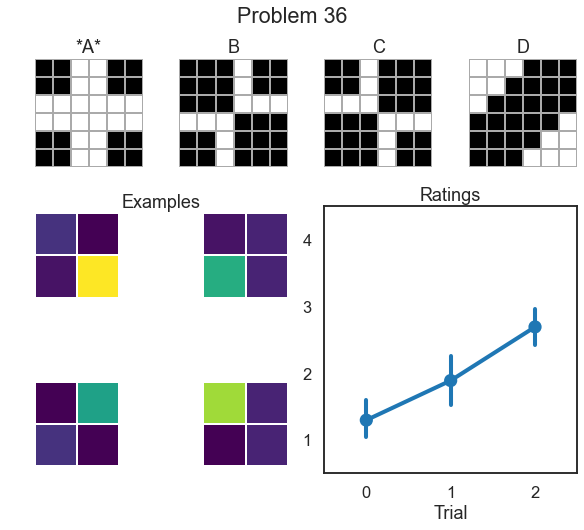

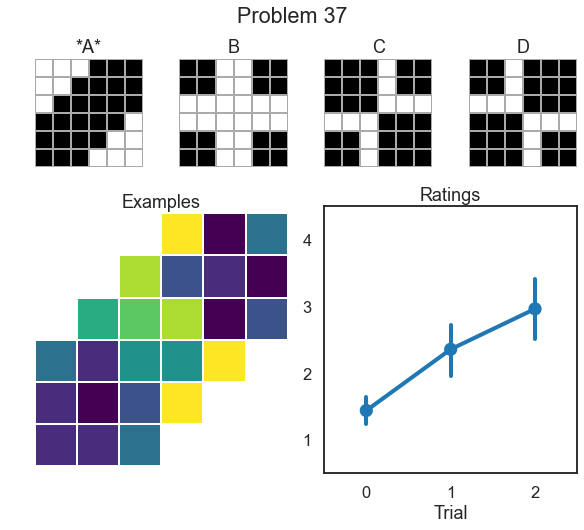

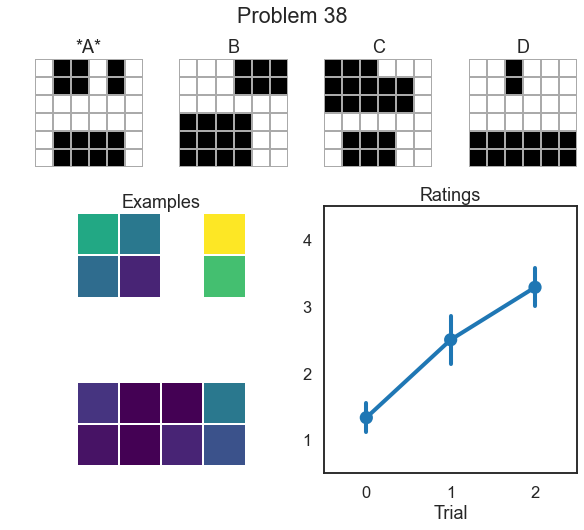

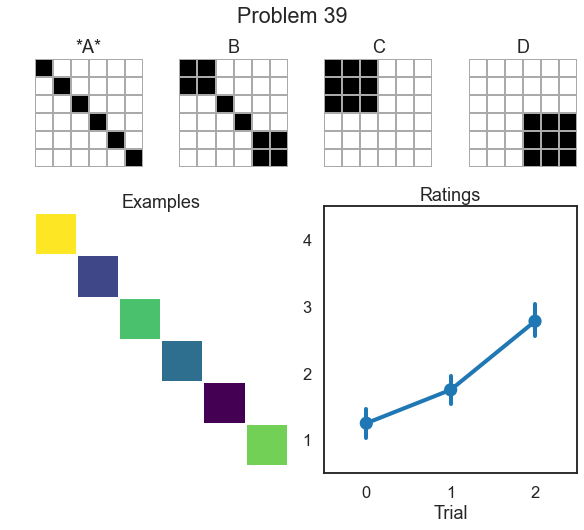

In [33]:
for idx in range(len(problems)):
    prob_fig = plot_problem(idx)
    plt.savefig('plots/examples_agg/problem_%02d.png' % idx)

In [ ]:
prob_idx